# Neural Network for Predicting Pedestrians Velocity

This notebook is the pipeline we used to preprocess dataset, train neural network and collect useful training results. Multiple settings of the neural network use the same pipeline here. 

In [1]:
# import all the required packages
import os
import datetime
import tensorboard
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import pytorch_lightning as pl

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

%load_ext autoreload
%autoreload 2
%matplotlib inline


#### Run this line if the notebook crashed when plotting something

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 1. Data Preparation

#### Path

In [4]:
root = os.getcwd()
vadere_dataset_path = os.path.join(root, "dataset", "vadere_generated")
website_dataset_path = os.path.join(root, "dataset", "website_generated")

#### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using the device",device)

Using the device cuda:0


### Data Preprocessing: Set contain_sk=True if training the network with the info of sk (NN2); contain_sk=False without sk(NN1)
Check codes: utils\vadereOutputLoader.py

#### The following codes load a trial dataset.

In [104]:
from utils.vadereOutputLoader import vadereOutputLoader

nameOfDataset = "trial_data.txt"
numOfNeighbours = 3
contain_sk = True
numOfCols = 4 + 2*numOfNeighbours - (not contain_sk)

rawdataLoader = vadereOutputLoader(vadere_dataset_path, vadere_dataset_path)
rawdata, sk = rawdataLoader.loadData(nameOfDataset, numOfNeighbours, need_processing=True, contain_sk=contain_sk, return_sk=True)

#### The following codes load the bottlenect/corridor datasets generated by vadere.

In [216]:
from utils.vadereOutputLoader import vadereOutputLoader

dataset_name_list = ["bottleneck_070.txt", "bottleneck_095.txt",
                     "bottleneck_120.txt", "bottleneck_180.txt"]

# dataset_name_list = ["corridor_015.txt", "corridor_030.txt",
#                      "corridor_060.txt", "corridor_085.txt",
#                      "corridor_095.txt", "corridor_110.txt",
#                      "corridor_140.txt", "corridor_230.txt"]

# dataset_name_list = ["coridor_new_030.txt",
#                      "coridor_new_060.txt", "coridor_new_085.txt",
#                      "coridor_new_095.txt", "coridor_new_110.txt",
#                      "coridor_new_140.txt", "coridor_new_230.txt"]

numOfNeighbours = 10
contain_sk = True
numOfCols = 4 + 2*numOfNeighbours - (not contain_sk)

rawdataLoader = vadereOutputLoader(
    vadere_dataset_path, vadere_dataset_path)
rawdata, sk = rawdataLoader.mergeDataset(
    dataset_name_list, "merged_corridor.txt", numOfNeighbours, need_processing=True, contain_sk=contain_sk, return_sk=True)


#### The following cell load the data from the database used by the paper

In [293]:
from utils.websiteOutputLoader import websiteOutputLoader

# nameOfDataset = "processed_uo-180-180-095_combined_MB.txt"
nameOfDataset = "processed_ug-180-095_combined_MB.txt"

numOfNeighbours = 10
contain_sk = False
numOfCols = 4 + 2*numOfNeighbours - (not contain_sk)

rawdataLoader = vadereOutputLoader(website_dataset_path, website_dataset_path)
rawdata, sk = rawdataLoader.loadData(nameOfDataset, numOfNeighbours, need_processing=False, contain_sk=contain_sk, return_sk=True)

#### Normalize the Relative positions:

In [294]:
from sklearn.preprocessing import normalize
rawdata[-2*numOfNeighbours:] = normalize(rawdata[-2*numOfNeighbours:], axis=0, norm="l2")

#### Customized Dataset class and Dataloaders: 
Check codes: utils\crowdDataset.py

In [295]:
from utils.crowdDataset import crowdDataset

total = len(rawdata)
np.random.seed(118010142)
randidx = np.arange(total)
np.random.shuffle(randidx)

train_idx = randidx[np.arange(int(total*.6))]
val_idx = randidx[np.arange(int(total*.6), int(total*.8))]
test_idx = randidx[np.arange(int(total*.8), total)]


train = crowdDataset(rawdata[train_idx], device)
val = crowdDataset(rawdata[val_idx], device)
test = crowdDataset(rawdata[test_idx], device)

batch_size = 64
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)


## 2. Training Neural Network

In [296]:
%tensorboard --logdir lightning_logs

UsageError: Line magic function `%tensorboard` not found.


#### Define the network
A simple example network is shown here. Modify the following block to construct different network structure.

In [297]:
from utils.network import FullyConnectedNet

hparams = {
    "numOfLayers": 2,
    "layerSize": [4, 2],
    "learning_rate": 0.0001
}

model = FullyConnectedNet(hparams=hparams, input_size=rawdata.shape[1]-1, output_size=1)

In [298]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# default logger used by trainer
logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    version=model.version,
    name='lightning_logs'
)

early_stop_callback = EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    verbose = False
)

trainer = pl.Trainer(
    max_epochs=200,
    progress_bar_refresh_rate=25,
    gpus=1,
    callbacks=[early_stop_callback],
    logger = logger
)
trainer.fit(model, train_dataloader=trainloader, val_dataloaders=valloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 67    
-----------------------------------------
67        Trainable params
0         Non-trainable params
67        Total params
0.000     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/1898 [00:00<?, ?it/s] 

C:\Users\Linnore\anaconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
C:\Users\Linnore\anaconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\data_loading.py:103: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Epoch 16: 100%|██████████| 1898/1898 [00:07<00:00, 253.65it/s, loss=0.601, v_num=1545]


#### Output summary of the trained model: 

d:\GitHub\MLCMS-Final-Project\NN2_model_summary\model_summary.txt exists, model summary will be attached to the end of this file.


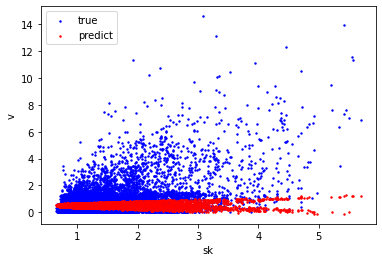

Plot saved as d:\GitHub\MLCMS-Final-Project\NN2_model_summary\plots\1_3_20210714-131545.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\NN2_model_summary\model_prediction\1_3_20210714-131545_prediction.txt


In [301]:
if contain_sk:
    summary_folder_path = os.path.join(root, "NN1_model_summary")
else:
    summary_folder_path = os.path.join(root, "NN2_model_summary")

vhat = model(torch.tensor(rawdata[test_idx, 1:], dtype=torch.float32)).detach().numpy().reshape(-1)
v = torch.tensor(rawdata[test_idx, 0], dtype=torch.float32).detach().numpy()

model.output_summary(v, vhat, sk[test_idx], trainer.logged_metrics, "B", "B", summary_folder_path)

## 3. Model selection

The following codes train the network with different architectures on the dataset B+C generated by Vadere.

In [21]:
from utils.vadereOutputLoader import vadereOutputLoader
from utils.crowdDataset import crowdDataset
from sklearn.preprocessing import normalize

dataset_name_list = ["merged_corridor.txt", "merged_bottleneck.txt"]

numOfNeighbours = 10
contain_sk = False
numOfCols = 4 + 2*numOfNeighbours - (not contain_sk)

rawdataLoader = vadereOutputLoader(
    vadere_dataset_path, vadere_dataset_path)
rawdata, sk = rawdataLoader.mergeDataset(
    dataset_name_list, "merged_corridor_plus_bottleneck.txt", numOfNeighbours, need_processing=False, contain_sk=contain_sk, return_sk=True)

from sklearn.preprocessing import normalize
rawdata[-2*numOfNeighbours:] = normalize(rawdata[-2*numOfNeighbours:], axis=0, norm="l2")

total = len(rawdata)
randidx = np.arange(total)
np.random.shuffle(randidx)

train_idx = randidx[np.arange(int(total*.6))]
val_idx = randidx[np.arange(int(total*.6), int(total*.8))]
test_idx = randidx[np.arange(int(total*.8), total)]


train = crowdDataset(rawdata[train_idx], device)
val = crowdDataset(rawdata[val_idx], device)
test = crowdDataset(rawdata[test_idx], device)

batch_size = 32
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 23    
-----------------------------------------
23        Trainable params
0         Non-trainable params
23        Total params
0.000     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/543 [00:00<?, ?it/s] 

C:\Users\Linnore\anaconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
C:\Users\Linnore\anaconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\data_loading.py:103: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Epoch 29: 100%|██████████| 543/543 [00:01<00:00, 356.89it/s, loss=0.121, v_num=4308]
Created file d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_summary.txt


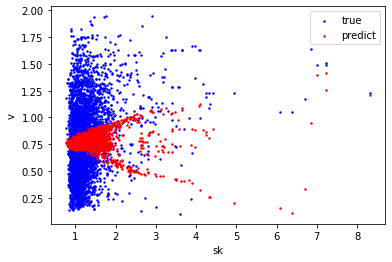

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 45    
-----------------------------------------
45        Trainable params
0         Non-trainable params
45        Total params
0.000     Total estimated model params size (MB)


Plot saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\plots\1_1_20210714-214308.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_prediction\1_1_20210714-214308_prediction.txt
Epoch 58: 100%|██████████| 543/543 [00:01<00:00, 347.22it/s, loss=0.117, v_num=4413]
d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_summary.txt exists, model summary will be attached to the end of this file.


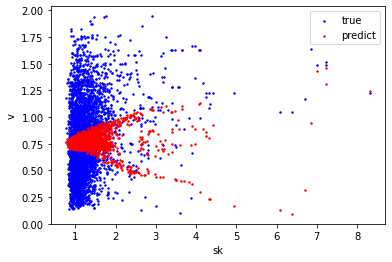

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 67    
-----------------------------------------
67        Trainable params
0         Non-trainable params
67        Total params
0.000     Total estimated model params size (MB)


Plot saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\plots\1_2_20210714-214413.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_prediction\1_2_20210714-214413_prediction.txt
Epoch 70: 100%|██████████| 543/543 [00:01<00:00, 349.11it/s, loss=0.12, v_num=4556]
d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_summary.txt exists, model summary will be attached to the end of this file.


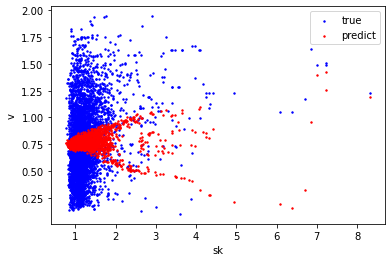

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 97    
-----------------------------------------
97        Trainable params
0         Non-trainable params
97        Total params
0.000     Total estimated model params size (MB)


Plot saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\plots\1_3_20210714-214556.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_prediction\1_3_20210714-214556_prediction.txt
Epoch 26: 100%|██████████| 543/543 [00:02<00:00, 268.66it/s, loss=0.102, v_num=4759]
d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_summary.txt exists, model summary will be attached to the end of this file.


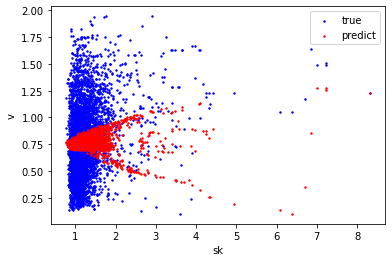

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 120   
-----------------------------------------
120       Trainable params
0         Non-trainable params
120       Total params
0.000     Total estimated model params size (MB)


Plot saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\plots\2_4_2_20210714-214759.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_prediction\2_4_2_20210714-214759_prediction.txt
Epoch 39: 100%|██████████| 543/543 [00:01<00:00, 323.01it/s, loss=0.108, v_num=4903]
d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_summary.txt exists, model summary will be attached to the end of this file.


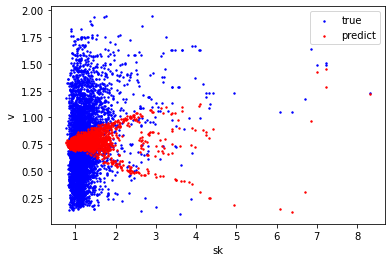

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 127   
-----------------------------------------
127       Trainable params
0         Non-trainable params
127       Total params
0.001     Total estimated model params size (MB)


Plot saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\plots\2_5_2_20210714-214903.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_prediction\2_5_2_20210714-214903_prediction.txt
Epoch 171: 100%|██████████| 543/543 [00:01<00:00, 315.71it/s, loss=0.106, v_num=5034]
d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_summary.txt exists, model summary will be attached to the end of this file.


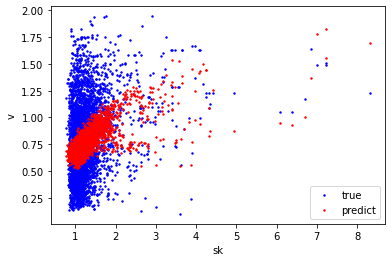

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 151   
-----------------------------------------
151       Trainable params
0         Non-trainable params
151       Total params
0.001     Total estimated model params size (MB)


Plot saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\plots\2_5_3_20210714-215034.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_prediction\2_5_3_20210714-215034_prediction.txt
Epoch 188: 100%|██████████| 543/543 [00:01<00:00, 315.24it/s, loss=0.0955, v_num=5627]
d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_summary.txt exists, model summary will be attached to the end of this file.


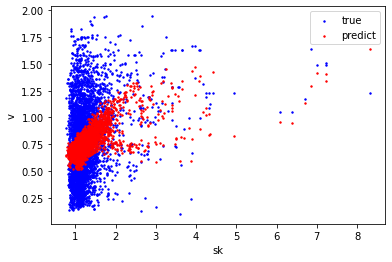

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 259   
-----------------------------------------
259       Trainable params
0         Non-trainable params
259       Total params
0.001     Total estimated model params size (MB)


Plot saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\plots\2_6_3_20210714-215627.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_prediction\2_6_3_20210714-215627_prediction.txt
Epoch 169: 100%|██████████| 543/543 [00:01<00:00, 323.59it/s, loss=0.101, v_num=0240]
d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_summary.txt exists, model summary will be attached to the end of this file.


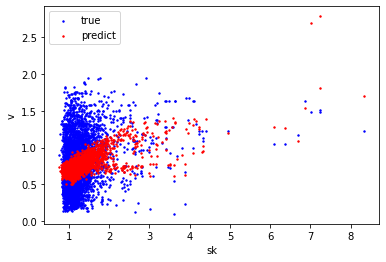

Plot saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\plots\2_10_4_20210714-220240.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\NN1_model_summary\model_prediction\2_10_4_20210714-220240_prediction.txt


In [22]:
from utils.network import FullyConnectedNet
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

hparams = {
    "numOfLayers": None,
    "layerSize": None,
    "learning_rate": 0.0001
}
nlayers_list = [1, 1, 1, 2, 2, 2, 2, 2]
layerSize_list = [[1], [2], [3], [4,2], [5,2], [5,3], [6,3], [10, 4]]


for i in range(len(nlayers_list)):
    hparams["numOfLayers"] = nlayers_list[i]
    hparams["layerSize"] = layerSize_list[i]
    
    model = FullyConnectedNet(hparams=hparams, input_size=rawdata.shape[1]-1, output_size=1)

    # default logger used by trainer
    logger = TensorBoardLogger(
        save_dir=os.getcwd(),
        version=model.version,
        name='lightning_logs'
    )

    early_stop_callback = EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        verbose = False
    )

    trainer = pl.Trainer(
        max_epochs=200,
        progress_bar_refresh_rate=25,
        gpus=1,
        callbacks=[early_stop_callback],
        logger = logger
    )
    trainer.fit(model, train_dataloader=trainloader, val_dataloaders=valloader)

    if contain_sk:
        summary_folder_path = os.path.join(root, "NN2_model_summary")
    else:
        summary_folder_path = os.path.join(root, "NN1_model_summary")

    vhat = model(torch.tensor(rawdata[test_idx, 1:], dtype=torch.float32)).detach().numpy().reshape(-1)
    v = torch.tensor(rawdata[test_idx, 0], dtype=torch.float32).detach().numpy()

    model.output_summary(v, vhat, sk[test_idx], trainer.logged_metrics, "vadereB+C", "vadereB+C", summary_folder_path)

#### Plot errors and aic

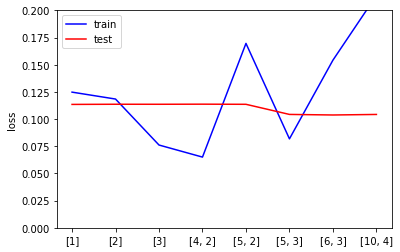

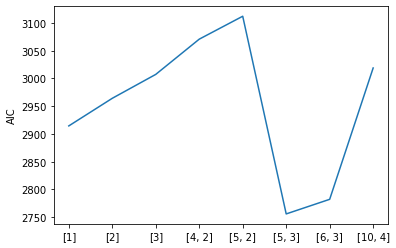

In [23]:
model_info = np.loadtxt(os.path.join(summary_folder_path, "model_summary.txt"), skiprows=1, usecols=[3, 4, 5])
train_loss = model_info[:, 0]
test_loss = model_info[:, 1]
aic = model_info[:, 2]

plt.plot(train_loss, color="blue", label="train")
plt.plot(test_loss, color="red", label="test")
plt.legend()
plt.xticks(np.arange(len(layerSize_list)), layerSize_list)
plt.ylabel("loss")
plt.ylim((0,0.20))
plt.savefig(os.path.join(summary_folder_path, "model_loss"))
plt.show()


plt.plot(aic)
plt.xticks(np.arange(len(layerSize_list)), layerSize_list)
plt.ylabel("AIC")
plt.savefig(os.path.join(summary_folder_path, "model_aic"))
plt.show()

#### Comparison

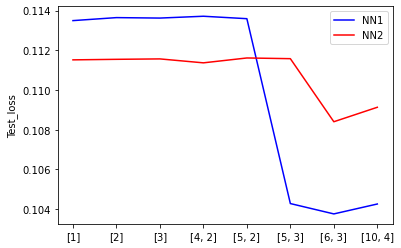

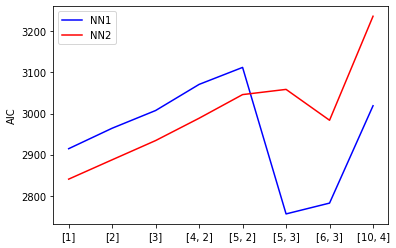

In [27]:
NN1_info = np.loadtxt(os.path.join(root, "NN1_model_summary", "model_summary.txt"), skiprows=1, usecols=[3, 4, 5])
nn1_train_loss = NN1_info[:, 0]
nn1_test_loss = NN1_info[:, 1]
nn1_aic = NN1_info[:, 2]

NN2_info = np.loadtxt(os.path.join(root, "NN2_model_summary", "model_summary.txt"), skiprows=1, usecols=[3, 4, 5])
nn2_train_loss = NN2_info[:, 0]
nn2_test_loss = NN2_info[:, 1]
nn2_aic = NN2_info[:, 2]

plt.plot(nn1_test_loss, color="blue", label="NN1")
plt.plot(nn2_test_loss, color="red", label="NN2")
plt.xticks(np.arange(len(layerSize_list)), layerSize_list)
plt.ylabel("Test_loss")
plt.legend()
plt.show()


plt.plot(nn1_aic, color="blue", label="NN1")
plt.plot(nn2_aic, color="red", label="NN2")
plt.xticks(np.arange(len(layerSize_list)), layerSize_list)
plt.ylabel("AIC")
plt.legend()
plt.show()